Loading data...
Selected the last 15000 rows for validation.
Applying feature engineering...
Feature engineering complete. Took 0.03 seconds.
Columns after features: 52
Defining target variable...
Preparing data for modeling...
Handled NaNs. Dropped 186 rows.
Replacing 10 infinite values with NaN...
Dropped 10 additional rows after handling infinites.
Defining Features (X) and Binary Target (y)...
Final feature matrix shape: (14804, 43)
Target vector shape: (14804,)
Number of feature columns used: 43

--- Starting SLIDING Window Backtest ---
Sliding Window Size: 1000, Step Size: 24
Processed 50 predictions. Timestamp: 2023-10-25 18:00:00. Cum. Acc: 0.8000
Processed 100 predictions. Timestamp: 2023-12-14 18:00:00. Cum. Acc: 0.7700
Processed 150 predictions. Timestamp: 2024-02-02 18:00:00. Cum. Acc: 0.7400
Processed 200 predictions. Timestamp: 2024-03-23 18:00:00. Cum. Acc: 0.7750
Processed 250 predictions. Timestamp: 2024-05-12 18:00:00. Cum. Acc: 0.7680
Processed 300 predictions. Times

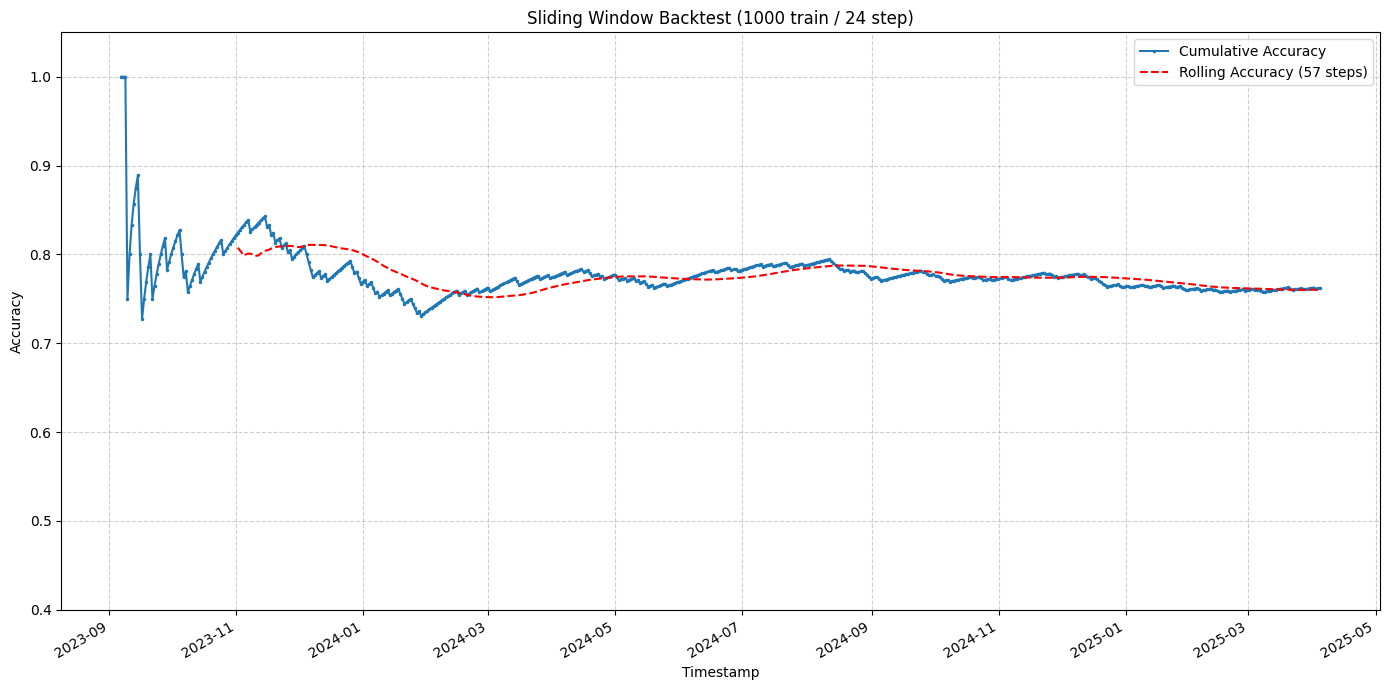


Script Simple_Predictor_B_Sliding.py finished.


In [1]:
# Simple_Predictor_B_Sliding.py
# Uses a SLIDING window for backtesting

import pandas as pd
import numpy as np
import time
import os
import warnings
import traceback
from datetime import datetime
import xgboost as xgb
import matplotlib.pyplot as plt # <-- Added import for plotting

# Feature Engineering Imports
# Note: pandas_ta is imported in the original but not explicitly used below
# If custom functions fail, consider reinstalling/using pandas_ta

# Modeling Imports (Keep relevant ones)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) # Specific warning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore') # General suppression

# --- 1. Load Data and Select Last Rows ---
print("Loading data...")
try:
    df_full = pd.read_csv('BTCUSDrec.csv')
    df_full = df_full.sort_values(by='unix', ascending=True).reset_index(drop=True)
    # Convert date column early if it exists
    if 'date' in df_full.columns:
        try:
            df_full['date'] = pd.to_datetime(df_full['date'])
        except Exception as e_date:
            print(f"Warning: Could not parse 'date' column, will rely on 'unix'. Error: {e_date}")

    # Use last N rows
    N_ROWS_TO_USE = 15000
    if len(df_full) < N_ROWS_TO_USE:
        print(f"Warning: Full dataset ({len(df_full)} rows) < {N_ROWS_TO_USE}. Using all data.")
        df = df_full.copy()
    else:
        df = df_full.iloc[-N_ROWS_TO_USE:].reset_index(drop=True)
        print(f"Selected the last {len(df)} rows for validation.")

except FileNotFoundError:
    print("Error: BTCUSDrec.csv not found."); exit()
except Exception as e:
    print(f"An error occurred loading data: {e}"); exit()

# --- 2. Feature Engineering (Using provided custom functions) ---
print("Applying feature engineering...")
start_fe = time.time()

# Ensure required base columns are numeric
base_cols_numeric = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
for col in base_cols_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Base column '{col}' not found.")
        if col in ['Volume BTC', 'Volume USD']: df[col] = 0 # Add volume cols if missing
        # OHLC presence checked later

# Check for OHLC NaNs early
if df[['open', 'high', 'low', 'close']].isnull().any().any():
    print("Warning: NaNs found in OHLC data during initial load. Dropping rows.")
    df = df.dropna(subset=['open', 'high', 'low', 'close'])
    if df.empty: exit("Error: DataFrame empty after dropping initial OHLC NaNs.")

# Basic Features
df['price_change_1h_temp'] = df['close'].pct_change() # Use temporary name
with np.errstate(divide='ignore', invalid='ignore'):
    df['price_range_pct'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan) * 100
    df['oc_change_pct'] = (df['close'] - df['open']) / df['open'].replace(0, np.nan) * 100

# Volatility Features
def garman_klass_volatility(open_, high, low, close, window):
    with np.errstate(divide='ignore', invalid='ignore'): # Suppress log(0) warnings
        log_hl = np.log(high / low.replace(0, np.nan))
        log_co = np.log(close / open_.replace(0, np.nan))
    gk = 0.5 * (log_hl ** 2) - (2*np.log(2) - 1) * (log_co ** 2)
    gk = gk.fillna(0) # Fill NaNs resulting from division/log issues before rolling
    rolling_mean = gk.rolling(window=window, min_periods=max(1, window//2)).mean()
    rolling_mean = rolling_mean.clip(lower=0) # Ensure non-negative variance
    return np.sqrt(rolling_mean)

def parkinson_volatility(high, low, window):
    with np.errstate(divide='ignore', invalid='ignore'): # Suppress log(0) warnings
        log_hl_sq = np.log(high / low.replace(0, np.nan)) ** 2
    log_hl_sq = log_hl_sq.fillna(0) # Fill NaNs before rolling
    rolling_sum = log_hl_sq.rolling(window=window, min_periods=max(1, window//2)).sum()
    factor = 1 / (4 * np.log(2) * window) if window > 0 else 0
    return np.sqrt(factor * rolling_sum)

df['garman_klass_12h'] = garman_klass_volatility(df['open'], df['high'], df['low'], df['close'], window=12)
df['parkinson_3h'] = parkinson_volatility(df['high'], df['low'], window=3)

# Moving Averages & Standard Deviations
min_periods_rolling = 2 # Minimum required periods for rolling calcs
df['ma_3h'] = df['close'].rolling(window=3, min_periods=min_periods_rolling).mean()
df['rolling_std_3h'] = df['close'].rolling(window=3, min_periods=min_periods_rolling).std() # Std of price

# Lagged Price Returns (using temporary 1h return)
lag_periods_price = [3, 6, 12, 24, 48, 72, 168]
for lag in lag_periods_price:
    # shift(lag) aligns return from 'lag' periods ago with current row
    df[f'lag_{lag}h_price_return'] = df['price_change_1h_temp'].shift(lag) * 100 # Scale to %

# Lagged Volume Returns
df['volume_return_1h'] = df['Volume BTC'].pct_change() * 100
lag_periods_volume = [3, 6, 12, 24]
for lag in lag_periods_volume:
     df[f'lag_{lag}h_volume_return'] = df['volume_return_1h'].shift(lag)

# Longer MAs and STDs
ma_periods = [6, 12, 24, 48, 72, 168]
for p in ma_periods:
    df[f'ma_{p}h'] = df['close'].rolling(window=p, min_periods=max(min_periods_rolling, p//2)).mean()

std_periods = [6, 12, 24, 48, 72, 168]
for p in std_periods:
    # Std Dev on returns is common
    df[f'rolling_std_{p}h'] = df['price_change_1h_temp'].rolling(window=p, min_periods=max(min_periods_rolling, p//2)).std() * 100 # Scale to %

# ATR
df['prev_close'] = df['close'].shift(1)
df['high_minus_low'] = df['high'] - df['low']
df['high_minus_prev_close'] = np.abs(df['high'] - df['prev_close'])
df['low_minus_prev_close'] = np.abs(df['low'] - df['prev_close'])
df['true_range'] = df[['high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close']].max(axis=1)
atr_periods = [14, 24, 48]
for p in atr_periods:
     df[f'atr_{p}h'] = df['true_range'].rolling(window=p, min_periods=max(1, p//2)).mean()
df = df.drop(columns=['prev_close', 'high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close', 'true_range'])

# Trend/Interaction Features
epsilon = 1e-9 # For safe division
for p in [24, 48, 168]:
    ma_col = f'ma_{p}h'
    if ma_col in df.columns:
        df[f'close_div_ma_{p}h'] = df['close'] / (df[ma_col] + epsilon)
    else: df[f'close_div_ma_{p}h'] = np.nan # Add NaN column if MA doesn't exist

if 'ma_12h' in df.columns and 'ma_48h' in df.columns: df[f'ma12_div_ma48'] = df['ma_12h'] / (df['ma_48h'] + epsilon)
else: df['ma12_div_ma48'] = np.nan
if 'ma_24h' in df.columns and 'ma_168h' in df.columns: df[f'ma24_div_ma168'] = df['ma_24h'] / (df['ma_168h'] + epsilon)
else: df['ma24_div_ma168'] = np.nan
if 'rolling_std_12h' in df.columns and 'rolling_std_72h' in df.columns: df['std12_div_std72'] = df['rolling_std_12h'] / (df['rolling_std_72h'] + epsilon)
else: df['std12_div_std72'] = np.nan
if 'price_range_pct' in df.columns: df['volume_btc_x_range'] = df['Volume BTC'] * df['price_range_pct']
else: df['volume_btc_x_range'] = np.nan

# Non-linear Transformations
if 'rolling_std_3h' in df.columns: df['rolling_std_3h_sq'] = df['rolling_std_3h'] ** 2
else: df['rolling_std_3h_sq'] = np.nan
if 'price_change_1h_temp' in df.columns: df['price_return_1h_sq'] = df['price_change_1h_temp'] ** 2 * 10000 # Scale %^2
else: df['price_return_1h_sq'] = np.nan
if 'rolling_std_12h' in df.columns: df['rolling_std_12h_sqrt'] = np.sqrt(df['rolling_std_12h'].clip(lower=0) + epsilon) # Clip before sqrt
else: df['rolling_std_12h_sqrt'] = np.nan

# Drop intermediate columns used only for feature calculation
cols_to_drop_intermediate = ['price_change_1h_temp']
df = df.drop(columns=[col for col in cols_to_drop_intermediate if col in df.columns])

print(f"Feature engineering complete. Took {time.time() - start_fe:.2f} seconds.")
print(f"Columns after features: {df.shape[1]}")

# --- 3. Define Target Variable ---
print("Defining target variable...")
# Calculate 12-hour future return
df['target_return_12h'] = df['close'].shift(-12).sub(df['close']).div(df['close'].replace(0, np.nan)).mul(100)
target_col = 'target_return_12h' # Use this for identifying the target column later

# --- 4. Prepare Data for Modeling ---
print("Preparing data for modeling...")

# Drop non-feature, non-identifier, non-target columns
cols_to_keep = ['unix', 'date', target_col] # Keep identifiers for indexing/plotting
feature_cols_initial = [col for col in df.columns if col not in cols_to_keep and col not in ['symbol', 'unix', 'date'] + base_cols_numeric]
# Also ensure base OHLCV are NOT features unless explicitly intended
feature_cols = [col for col in feature_cols_initial if col not in base_cols_numeric]

df_model_ready = df[feature_cols + cols_to_keep].copy() # Keep only necessary cols

# Handle NaNs (Crucial: Drop rows with ANY NaN after feature/target calc)
initial_rows = len(df_model_ready)
df_model_ready = df_model_ready.dropna() # Drop rows with NaNs in EITHER features OR target
final_rows = len(df_model_ready)
print(f"Handled NaNs. Dropped {initial_rows - final_rows} rows.")

# Handle potential Infinite values
numeric_cols = df_model_ready.select_dtypes(include=np.number).columns.tolist()
numeric_cols_check = [col for col in numeric_cols if col not in [target_col, 'unix']] # Exclude target and unix
inf_mask = np.isinf(df_model_ready[numeric_cols_check])
inf_count = inf_mask.sum().sum()
if inf_count > 0:
    print(f"Replacing {inf_count} infinite values with NaN...")
    df_model_ready.replace([np.inf, -np.inf], np.nan, inplace=True)
    rows_before_inf_drop = len(df_model_ready)
    df_model_ready = df_model_ready.dropna() # Drop rows again if inf->NaN created new NaNs
    print(f"Dropped {rows_before_inf_drop - len(df_model_ready)} additional rows after handling infinites.")

if df_model_ready.empty:
    exit("Error: DataFrame is empty after NaN/Inf handling. Cannot proceed.")

# Define Features (X) and Binary Target (y)
print("Defining Features (X) and Binary Target (y)...")
# Features are columns NOT in cols_to_keep
final_feature_cols = [col for col in df_model_ready.columns if col not in cols_to_keep]
X = df_model_ready[final_feature_cols]
y_binary = (df_model_ready[target_col] >= 0).astype(int) # Binary target: 1 if >=0% increase, 0 otherwise

# Get timestamps for results (use 'date' if available, else 'unix')
if 'date' in df_model_ready.columns:
    timestamps = df_model_ready['date']
elif 'unix' in df_model_ready.columns:
    timestamps = pd.to_datetime(df_model_ready['unix'], unit='ms') # Assuming unix is in ms
else:
    print("Warning: No 'date' or 'unix' column found for timestamps.")
    timestamps = pd.Series(range(len(df_model_ready))) # Fallback to index

print(f"Final feature matrix shape: {X.shape}")
print(f"Target vector shape: {y_binary.shape}")
print(f"Number of feature columns used: {len(final_feature_cols)}")
# print("Feature columns:", final_feature_cols) # Optional: print feature names


# --- 5. SLIDING Window Backtesting with Regularization ---
print("\n--- Starting SLIDING Window Backtest ---")

# Backtesting Parameters
train_window_size = 1000 # **** FIXED size for the sliding window ****
step_size = 24           # Retrain and predict every 24 hours (steps forward)
reg_alpha = 0.1          # L1 Regularization
reg_lambda = 0.1         # L2 Regularization
n_estimators = 100       # Number of trees
max_depth = 4            # Max depth of trees

# Check if enough data exists for at least one window + step
if len(X) < train_window_size + step_size:
     print(f"Error: Not enough data ({len(X)} points) for train window ({train_window_size}) + step ({step_size}).")
     exit()

# Store results
all_predictions = []
all_actual = []
all_probabilities = []
backtest_timestamps = []
cumulative_accuracy_list = []

# Loop through the data using the SLIDING window
num_predictions = 0
num_correct_predictions = 0

# Start loop index so the FIRST training window has size 'train_window_size'
start_index_loop = train_window_size
end_index_loop = len(X)

print(f"Sliding Window Size: {train_window_size}, Step Size: {step_size}")

for i in range(start_index_loop, end_index_loop, step_size):
    # Define train indices for this SLIDING window iteration
    train_idx_start = i - train_window_size
    train_idx_end = i
    test_idx = i # Predict the point immediately after the training window

    # Ensure test index does not go out of bounds (redundant with loop range but safe)
    if test_idx >= len(X):
        break

    # Get train and test sets for this fold
    X_train_roll = X.iloc[train_idx_start : train_idx_end] # <-- SLIDING WINDOW
    y_train_roll = y_binary.iloc[train_idx_start : train_idx_end] # <-- SLIDING WINDOW
    X_test_roll = X.iloc[test_idx : test_idx + 1] # Test on the single next point
    y_test_roll_actual = y_binary.iloc[test_idx]
    current_timestamp = timestamps.iloc[test_idx]

    # Check if training data is valid
    if X_train_roll.empty or len(y_train_roll.unique()) < 2:
        print(f"Warning: Skipping prediction at index {test_idx}. Invalid training data (empty or single class).")
        continue # Skip this step

    # Initialize and Train XGBoost Model with Regularization
    model_roll = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=0.1,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        reg_alpha=reg_alpha,   # L1 regularization
        reg_lambda=reg_lambda  # L2 regularization
    )

    try:
        model_roll.fit(X_train_roll, y_train_roll, verbose=False) # verbose=False

        # Make prediction
        pred_roll = model_roll.predict(X_test_roll)[0]
        prob_roll = model_roll.predict_proba(X_test_roll)[0, 1] # Prob of class 1

        # Store results
        all_predictions.append(pred_roll)
        all_actual.append(y_test_roll_actual)
        all_probabilities.append(prob_roll)
        backtest_timestamps.append(current_timestamp)

        # Update cumulative accuracy
        num_predictions += 1
        if pred_roll == y_test_roll_actual:
            num_correct_predictions += 1
        cumulative_accuracy = num_correct_predictions / num_predictions if num_predictions > 0 else 0
        cumulative_accuracy_list.append(cumulative_accuracy)

        # Print progress
        if num_predictions % 50 == 0:
             print(f"Processed {num_predictions} predictions. Timestamp: {current_timestamp}. Cum. Acc: {cumulative_accuracy:.4f}")

    except Exception as e_fit:
        print(f"Error during model fitting/prediction at index {test_idx}: {e_fit}")
        # Optionally store NaN or skip this step's results
        continue

print(f"\nBacktesting finished. Made {num_predictions} predictions.")

# --- 6. Evaluate Backtesting Results ---
if num_predictions > 0:
    # Calculate final metrics
    final_accuracy = accuracy_score(all_actual, all_predictions)
    final_precision = precision_score(all_actual, all_predictions, zero_division=0)
    final_recall = recall_score(all_actual, all_predictions, zero_division=0)
    final_f1 = f1_score(all_actual, all_predictions, zero_division=0)

    print("\n--- SLIDING Window Backtesting Performance Metrics ---")
    print(f"Overall Accuracy:  {final_accuracy:.4f}")
    print(f"Overall Precision: {final_precision:.4f}")
    print(f"Overall Recall:    {final_recall:.4f}")
    print(f"Overall F1 Score:  {final_f1:.4f}")

    # --- 7. Plot Cumulative Accuracy Over Time ---
    print("\nPlotting cumulative accuracy...")
    try:
        plt.figure(figsize=(14, 7)) # Wider figure
        plt.plot(backtest_timestamps, cumulative_accuracy_list, marker='.', linestyle='-', markersize=3, label='Cumulative Accuracy')
        # Add a rolling accuracy line for more insight
        rolling_window_plot = min(num_predictions // 10, 200) # e.g., 10% or max 200 steps
        if num_predictions > rolling_window_plot:
             rolling_acc = pd.Series(cumulative_accuracy_list).rolling(window=rolling_window_plot).mean()
             plt.plot(backtest_timestamps, rolling_acc, linestyle='--', color='red', label=f'Rolling Accuracy ({rolling_window_plot} steps)')

        plt.title(f'Sliding Window Backtest ({train_window_size} train / {step_size} step)')
        plt.xlabel('Timestamp')
        plt.ylabel('Accuracy')
        plt.ylim(0.4, max(0.8, np.max(cumulative_accuracy_list) + 0.05)) # Dynamic upper limit, min 0.8
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.xticks(rotation=30, ha='right') # Better rotation
        plt.tight_layout()
        plt.show()
    except Exception as e_plot:
        print(f"Error during plotting: {e_plot}")

else:
    print("No predictions were made, cannot evaluate performance or plot.")

print("\nScript Simple_Predictor_B_Sliding.py finished.")

In [4]:
X.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
       'price_range_pct', 'oc_change_pct', 'garman_klass_12h', 'parkinson_3h',
       'ma_3h', 'rolling_std_3h', 'lag_3h_price_return', 'lag_6h_price_return',
       'lag_12h_price_return', 'lag_24h_price_return', 'lag_48h_price_return',
       'lag_72h_price_return', 'lag_168h_price_return', 'volume_return_1h',
       'lag_3h_volume_return', 'lag_6h_volume_return', 'lag_12h_volume_return',
       'lag_24h_volume_return', 'ma_6h', 'ma_12h', 'ma_24h', 'ma_48h',
       'ma_72h', 'ma_168h', 'rolling_std_6h', 'rolling_std_12h',
       'rolling_std_24h', 'rolling_std_48h', 'rolling_std_72h',
       'rolling_std_168h', 'atr_14h', 'atr_24h', 'atr_48h', 'close_div_ma_24h',
       'close_div_ma_48h', 'close_div_ma_168h', 'ma12_div_ma48',
       'ma24_div_ma168', 'std12_div_std72', 'volume_btc_x_range',
       'rolling_std_3h_sq', 'price_return_1h_sq', 'rolling_std_12h_sqrt'],
      dtype='object')

What Now?

This is great progress! It tells you that predicting 12-hour direction is a much more promising path with your data and feature types.

Stick with the Simpler Structure (for now): Keep the single model (XGBoost) and the expanding window backtest for now.

Optimize This Setup:

Apply VIF: Now that you have a working model structure and a seemingly viable target, apply VIF filtering (e.g., threshold 5 or even your strict 1.69) to the features generated in this simpler script. Does reducing collinearity now improve the already decent results?

Tune Hyperparameters: Tune the XGBoost parameters (n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight) using a method like Optuna or RandomizedSearchCV within the rolling backtest loop (similar to how the meta-learner was tuned, but now for the single main model).

Experiment with Target Horizon: Is 12 hours optimal for the >0% target? Try 8 hours, 24 hours.

Experiment with Training Window: Does the expanding window work best, or would a large sliding window perform better for this target?

You've found a much better baseline. Now optimize it systematically!